In [ ]:

import pystac_client
import planetary_computer
import odc.stac
import geopandas as gpd
import dask.distributed
import matplotlib.pyplot as plt
import rioxarray
from datetime import datetime, timedelta



nps = gpd.read_file("/vsicurl/https://huggingface.co/datasets/cboettig/biodiversity/resolve/main/data/NPS.gdb")
calfire = gpd.read_file("/vsicurl/https://huggingface.co/datasets/cboettig/biodiversity/resolve/main/data/fire22_1.gdb",  layer = "firep22_1")
# fire = gpd.read_file("/vsizip/vsicurl/https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/MTBS_Fire/data/composite_data/burned_area_extent_shapefile/mtbs_perimeter_data.zip"

# extract and reproject the Joshua Tree NP Polygon
jtree = nps[nps.PARKNAME == "Joshua Tree"].to_crs(calfire.crs)

# All Fires in the DB that intersect the Park
jtree_fires = jtree.overlay(calfire, how="intersection")

# Extract a polygon if interest.   > 2015 for Sentinel, otherwise we can use LandSat
recent = jtree_fires[jtree_fires.YEAR_ > "2015"]
big = recent[recent.Shape_Area == recent.Shape_Area.max()].to_crs("EPSG:4326")

# Get bounding box + dates before & after fire for STAC search
box = big.buffer(0.01).bounds.to_numpy()[0]  # Fire bbox + buffer
alarm_date = datetime.strptime(big.ALARM_DATE.item(), "%Y-%m-%dT%H:%M:%S+00:00")  
before_date = alarm_date - timedelta(days=14)
after_date = alarm_date + timedelta(days=14)
search_dates = before_date.strftime("%Y-%m-%d") + "/" + after_date.strftime("%Y-%m-%d")



In [10]:

def stac_search(box, datetime):    
    # STAC Search for this imagery in space/time window
    items = (
        pystac_client.Client.
        open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD").
        search(collections=["HLSL30.v2.0"],
                bbox=box,
                datetime=datetime).
        item_collection())
    return items

def compute_ndvi(items, box):
    # Time to compute:
    client = dask.distributed.Client()
    # landsat_bands = ["nir08",  "swir16"]
    sentinel_bands = ["B05", "B04", "Fmask"] # NIR, SWIR, and Cloud Mask

    # The magic of gdalwarper. Can also resample, reproject, and aggregate on the fly
    data = odc.stac.load(items,
                        bands=sentinel_bands,
                        bbox=box,
                        crs="EPSG:32611"
    )

    red = data["B04"].astype("float")
    nir = data["B05"].astype("float")

    # can resample and aggregate in xarray. compute with dask
    ndvi = ((nir - red) / (nir + red)).compute()
    
    return ndvi


In [11]:


items = stac_search(box, search_dates)
items

In [20]:
href = "https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T11SNT.2022135T182205.v2.0/HLS.L30.T11SNT.2022135T182205.v2.0.B04.tif"
import rioxarray
import xarray
import rasterio
import os
from pathlib import Path
cookies = os.path.expanduser("~/.urs_cookies")
Path(cookies).touch()

with rasterio.Env(GDAL_HTTP_COOKIEFILE=cookies, 
                    GDAL_HTTP_COOKIEJAR=cookies, 
                    GDAL_HTTP_NETRC=True):
  x = xarray.open_dataset(href)



In [28]:
big.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [55]:
client = dask.distributed.Client()
# landsat_bands = ["nir08",  "swir16"]
sentinel_bands = ["B05", "B04"] # NIR, SWIR, and Cloud Mask


with rasterio.Env(GDAL_HTTP_COOKIEFILE=cookies, 
                    GDAL_HTTP_COOKIEJAR=cookies, 
                    GDAL_HTTP_NETRC=True):
    # The magic of gdalwarper. Can also resample, reproject, and aggregate on the fly
    data = odc.stac.load(items,
                        bands=sentinel_bands,
                        geopolygon=big,
                        resolution = 30
    )



/opt/conda/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42151 instead
  warnings.warn(


In [56]:
data.B04

<xarray.DataArray 'B04' (time: 7, latitude: 1, longitude: 1)>
array([[[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]]], dtype=float32)
Coordinates:
  * latitude     (latitude) float64 45.0
  * longitude    (longitude) float64 -105.0
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2022-05-15T18:22:05.159000 ... 2022-06...

In [57]:

red = data["B04"].astype("float")
nir = data["B05"].astype("float")

# can resample and aggregate in xarray. compute with dask
ndvi = ((nir - red) / (nir + red)).compute()

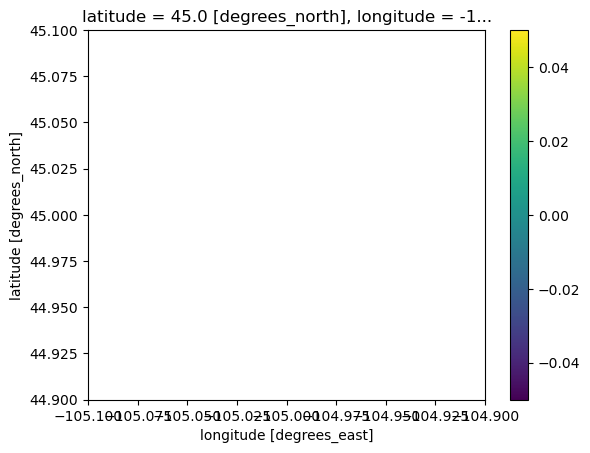

In [58]:
ndvi.isel(time=0).plot.imshow(cmap="viridis")


In [48]:

# write first and last date to tif
ndvi.isel(time=0).rio.to_raster(raster_path="before.tif", driver="COG")
ndvi.isel(time=(ndvi.time.size-1)).rio.to_raster(raster_path="after.tif", driver="COG")
